# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import string
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import nltk
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download("stopwords")
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\golov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
data = pd.read_csv('train.csv')

In [6]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

In [8]:
train["text"]

1186    Ashes 2015: AustraliaÛªs collapse at Trent Br...
4071    GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...
5461    CNN: Tennessee movie theater shooting suspect ...
5787    Still rioting in a couple of hours left until ...
7445    Crack in the path where I wiped out this morni...
                              ...                        
5226    @Eganator2000 There aren't many Obliteration s...
5390    just had a panic attack bc I don't have enough...
860     Omron HEM-712C Automatic Blood Pressure Monito...
7603    Officials say a quarantine is in place at an A...
7270    I moved to England five years ago today. What ...
Name: text, Length: 5329, dtype: object

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [9]:
train = train.fillna("")
test = test.fillna("")

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

0    3024
1    2305
Name: target, dtype: int64


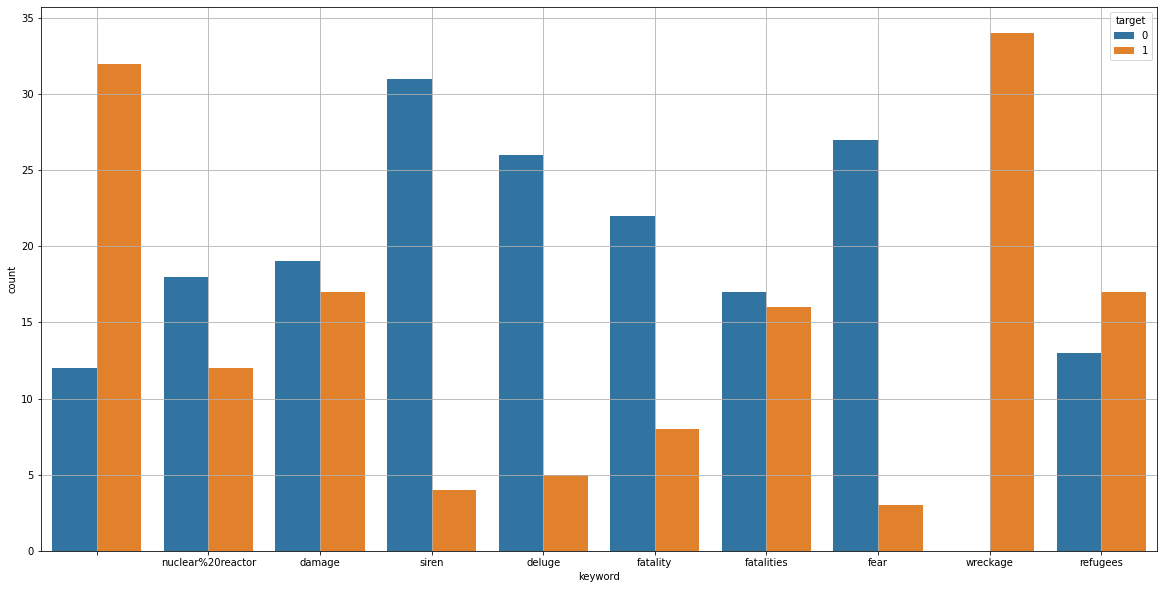

In [10]:
print(train["target"].value_counts())
x = train[train["keyword"].isin(train["keyword"].value_counts()[:10].index.to_list())]
ax = plt.figure(figsize = (20,10))
ax = sns.countplot(x = 'keyword', hue = 'target', data = x)
ax.grid()

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [11]:
train = train.drop("id",axis = 1)
train["concat"] = train["keyword"] + train["location"] + train["text"]
test = test.drop("id",axis = 1)
test["concat"] = test["keyword"] + test["location"] + test["text"]

## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
count_vector = count.fit_transform(train["concat"])
count_vector.shape

(5329, 22738)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [13]:
def count_all(vec):
    digit_count = 0
    punct_count = 0
    hash_count = 0
    for i in (vec.vocabulary_).keys():
        if i[0] == "#" or i[0] == "@":
            hash_count += 1
        if any([t.isdigit() for t in i]):
            digit_count += 1
        if any([t in string.punctuation for t in i]):
            punct_count += 1
    print("Punctuation number =",punct_count)
    print("Digits number =", digit_count)
    print("Hash number=", hash_count)

In [14]:
count_all(count)

Punctuation number = 317
Digits number = 4590
Hash number= 0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [15]:

#help(TweetTokenizer)
count1 = CountVectorizer(tokenizer = TweetTokenizer().tokenize)
count_vector1 = count1.fit_transform(train["concat"])
count_all(count1)


Punctuation number = 7573
Digits number = 4609
Hash number= 3152


## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [44]:
for i in "aaskmxkmskmx":
    print(i + " = ",i in r"[a-zA-Z]+")
"ûªs".isascii()

a =  True
a =  True
s =  False
k =  False
m =  False
x =  False
k =  False
m =  False
s =  False
k =  False
m =  False
x =  False


False

In [45]:
def sift(array):
    brackets = "{}[]()"
    ans = list()
    for i in array:
        if i not in nltk.corpus.stopwords.words('english'):
            if i.isalpha() and i.isascii():
                ans.append(i)
            elif i[0] == "#" and i[1:].isalpha() and i[1:].isascii() :
                ans.append(i)
            elif all(j in string.punctuation for j in i) and any(k in brackets for k in i):
                ans.append(i)
    return ans


In [46]:
def custom_tokenizer(string):
    string = string.lower()
    tokenized = TweetTokenizer().tokenize(string)
    tokenized = sift(tokenized)
    stemmer = SnowballStemmer('english')
    tokenized = [stemmer.stem(i) for i in tokenized]
    return tokenized
    

In [47]:
ans = list()
for i in train["concat"].to_list()[:10]:
    ans.append(custom_tokenizer(i))
ans

[['bridg',
  'australia',
  'collaps',
  'trent',
  'bridg',
  'among',
  'worst',
  'histori',
  'england',
  'bundl',
  'australia'],
 ['hailcarol',
  'stream',
  'illinoisgreat',
  'michigan',
  'techniqu',
  'camp',
  'thank',
  '#goblu',
  '#wrestleon'],
 ['policehouston',
  'cnn',
  'tennesse',
  'movi',
  'theater',
  'shoot',
  'suspect',
  'kill',
  'polic'],
 ['riotingstil', 'riot', 'coupl', 'hour', 'left', 'class'],
 ['woundslak',
  'highlandscrack',
  'path',
  'wipe',
  'morn',
  'beach',
  'run',
  'surfac',
  'wound',
  'left',
  'elbow',
  'right',
  'knee'],
 ['airplan',
  'thereexpert',
  'franc',
  'begin',
  'examin',
  'airplan',
  'debri',
  'found',
  'reunion',
  'island',
  'french',
  'air',
  'accid',
  'expert',
  '#mlb'],
 ['bloodyisol',
  'citi',
  'world',
  'came',
  'kill',
  'indian',
  'fun',
  'video',
  'smirk',
  'remorseless',
  'pakistani',
  'killer',
  'show',
  'boast'],
 ['burn', 'except', 'idk', 'realli', 'burn'],
 ['destroyh', '(', 'ask', '

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [48]:
y_train = train["target"]
y_test = test["target"]

In [67]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import f1_score
count2 = CountVectorizer(tokenizer = custom_tokenizer)
cv_train = count2.fit_transform(train["concat"])
cv_test = count2.transform(test["concat"])
logreg_1 = LogisticRegression(max_iter=300, random_state=42)
logreg_1.fit(cv_train, y_train)
cv_res = logreg_1.predict(cv_test)
print(classification_report(y_test, cv_res))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1318
           1       0.79      0.69      0.74       966

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.79      2284
weighted avg       0.79      0.79      0.79      2284

0.740618101545254


## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [64]:
tf_vect = TfidfVectorizer(tokenizer = custom_tokenizer, max_df = 0.9, min_df = 0.01)
tf_train = tf_vect.fit_transform(train["concat"])
tf_test = tf_vect.transform(test["concat"])
logreg_2 = LogisticRegression(max_iter=300, random_state=42)
logreg_2.fit(tf_train, y_train)
tf_res = logreg_2.predict(tf_test)
print(classification_report(y_test, tf_res))

              precision    recall  f1-score   support

           0       0.71      0.85      0.78      1318
           1       0.73      0.53      0.61       966

    accuracy                           0.72      2284
   macro avg       0.72      0.69      0.69      2284
weighted avg       0.72      0.72      0.71      2284



## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [65]:
from sklearn.feature_extraction.text import HashingVectorizer
hash_v = HashingVectorizer(tokenizer = custom_tokenizer, n_features = 5000)
hashv_train = hash_v.fit_transform(train["concat"])
hashv_test = hash_v.transform(test["concat"])
logreg_3 = LogisticRegression(max_iter=300, random_state=42)
logreg_3.fit(hashv_train, y_train)
hashv_res = logreg_3.predict(hashv_test)
print(classification_report(y_test, hashv_res))

C:\Users\golov\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1318
           1       0.79      0.64      0.71       966

    accuracy                           0.77      2284
   macro avg       0.78      0.76      0.76      2284
weighted avg       0.78      0.77      0.77      2284



## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.